In [2]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === Load Dataset ===


df = pd.read_csv('/content/drive/MyDrive/Data mining final crop /Crop_recommendation.csv')

# === Basic Info ===
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
print("Unique Crops:", df['label'].unique())
print("Crop Count:\n", df['label'].value_counts())
# === Summary Table ===
summary = pd.pivot_table(df, index='label', aggfunc='mean')

Shape: (2200, 8)
Columns: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')
Data Types:
 N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object
Missing Values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Duplicates: 0
Unique Crops: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
Crop Count:
 label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
g

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# === Prepare Data ===
X = df.drop('label', axis=1)
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train, Validation, Test Split ===
# First: split into 70% train and 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, random_state=0, stratify=y
)

# Second: split the 30% temp into 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=0, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1540, 7) (1540,)
Validation shape: (330, 7) (330,)
Test shape: (330, 7) (330,)


In [4]:
# === Nutrient Visualizations ===
def nutrient_barplots(nutrient):
    sorted_summary = summary.sort_values(by=nutrient, ascending=False)
    fig = make_subplots(rows=1, cols=2)

    top = sorted_summary[nutrient][:10].sort_values()
    last = sorted_summary[nutrient][-10:]

    fig.add_trace(go.Bar(x=top.values, y=top.index, orientation='h', name=f"Most {nutrient}", text=top.values), row=1, col=1)
    fig.add_trace(go.Bar(x=last.values, y=last.index, orientation='h', name=f"Least {nutrient}", text=last.values), row=1, col=2)

    fig.update_traces(texttemplate='%{text}', textposition='inside')
    fig.update_layout(title_text=f"{nutrient} Requirement", plot_bgcolor='white', font_size=12, height=500)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

nutrient_barplots('N')
nutrient_barplots('P')
nutrient_barplots('K')


In [5]:
# === Grouped Bar Plot for NPK ===
fig = go.Figure()
for nutrient, color in zip(['N', 'P', 'K'], ['indianred', 'lightsalmon', 'crimson']):
    fig.add_trace(go.Bar(x=summary.index, y=summary[nutrient], name=nutrient, marker_color=color))
fig.update_layout(title="N, P, K Comparison Across Crops", barmode='group', xaxis_tickangle=-45)
fig.show()


In [6]:
# === Rainfall, Temperature, Humidity Comparison ===
fig = px.bar(summary, x=summary.index, y=["rainfall", "temperature", "humidity"])
fig.update_layout(title_text="Rainfall, Temperature, Humidity Comparison", plot_bgcolor='white', height=500)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


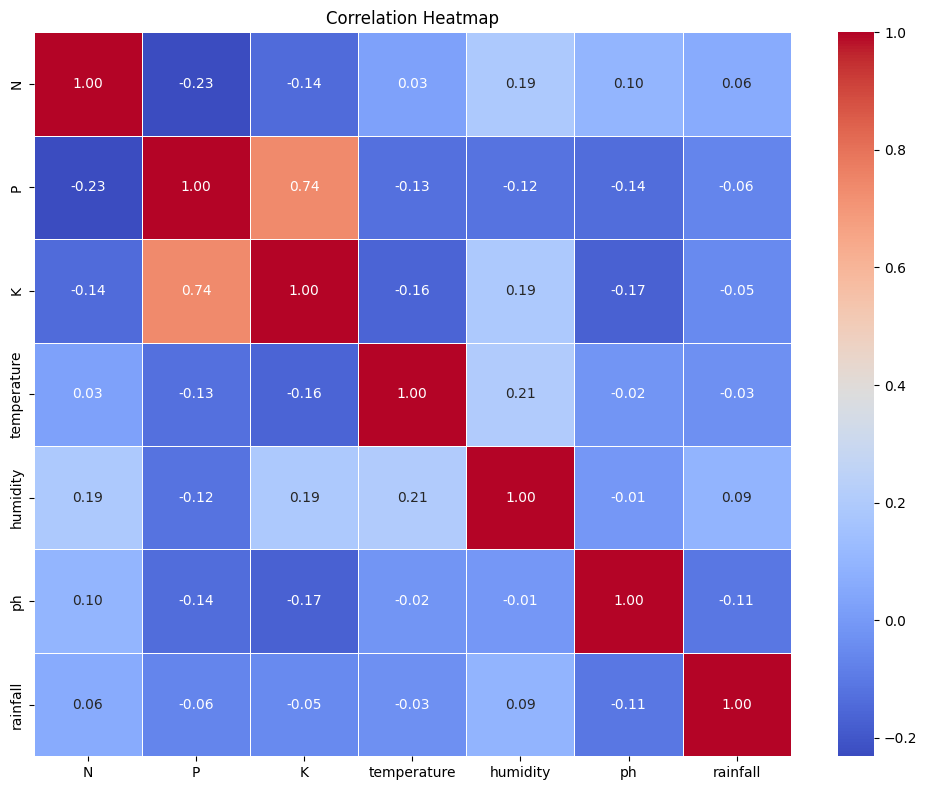

In [7]:
# === Correlation Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [8]:
# === Model Training & Evaluation ===
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(verbosity=0),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(verbosity=0),

}

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

results = []
for name, model in models.items():
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred) * 100
    results.append((name, acc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
display(results_df)

,Model,Accuracy
3,Random Forest,99.393939
7,Naive Bayes,99.393939
5,XGBoost,99.090909
2,Decision Tree,98.787879
4,Gradient Boosting,98.787879
1,SVM,97.878788
6,K-Nearest Neighbors,97.575758
0,Logistic Regression,96.969697


In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_best)
print("Test set accuracy of the best model:", test_accuracy)

Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy: 0.9948051948051948
Test set accuracy of the best model: 0.9939393939393939


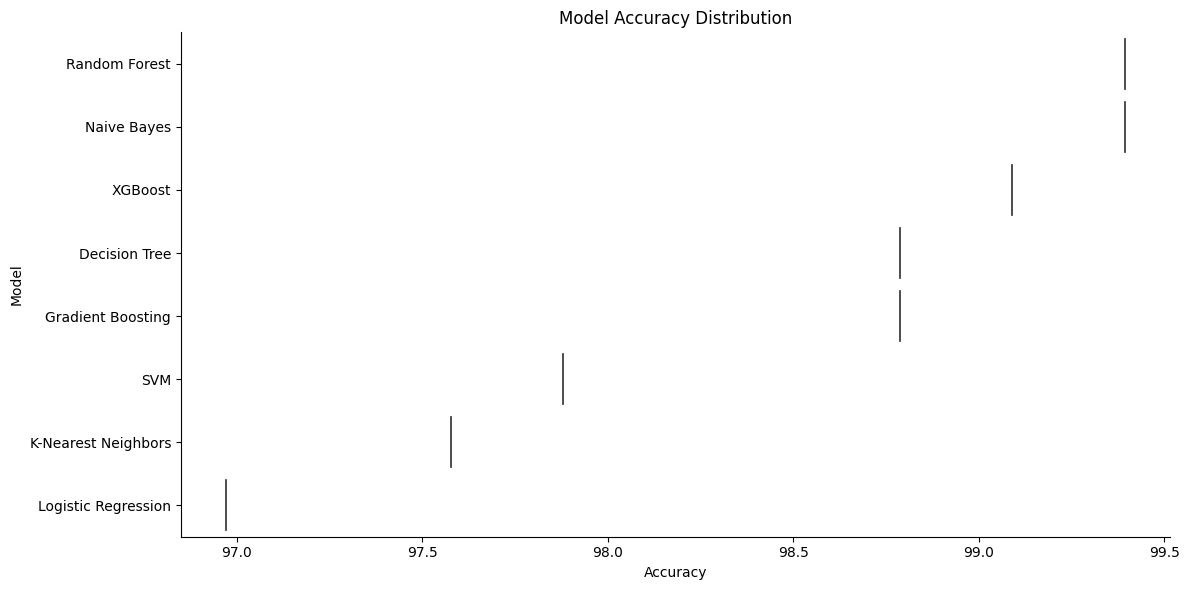

In [10]:
# === Accuracy Visualizations ===
plt.figure(figsize=(12, 6))
sns.violinplot(data=results_df, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine()
plt.title("Model Accuracy Distribution")
plt.tight_layout()
plt.show()

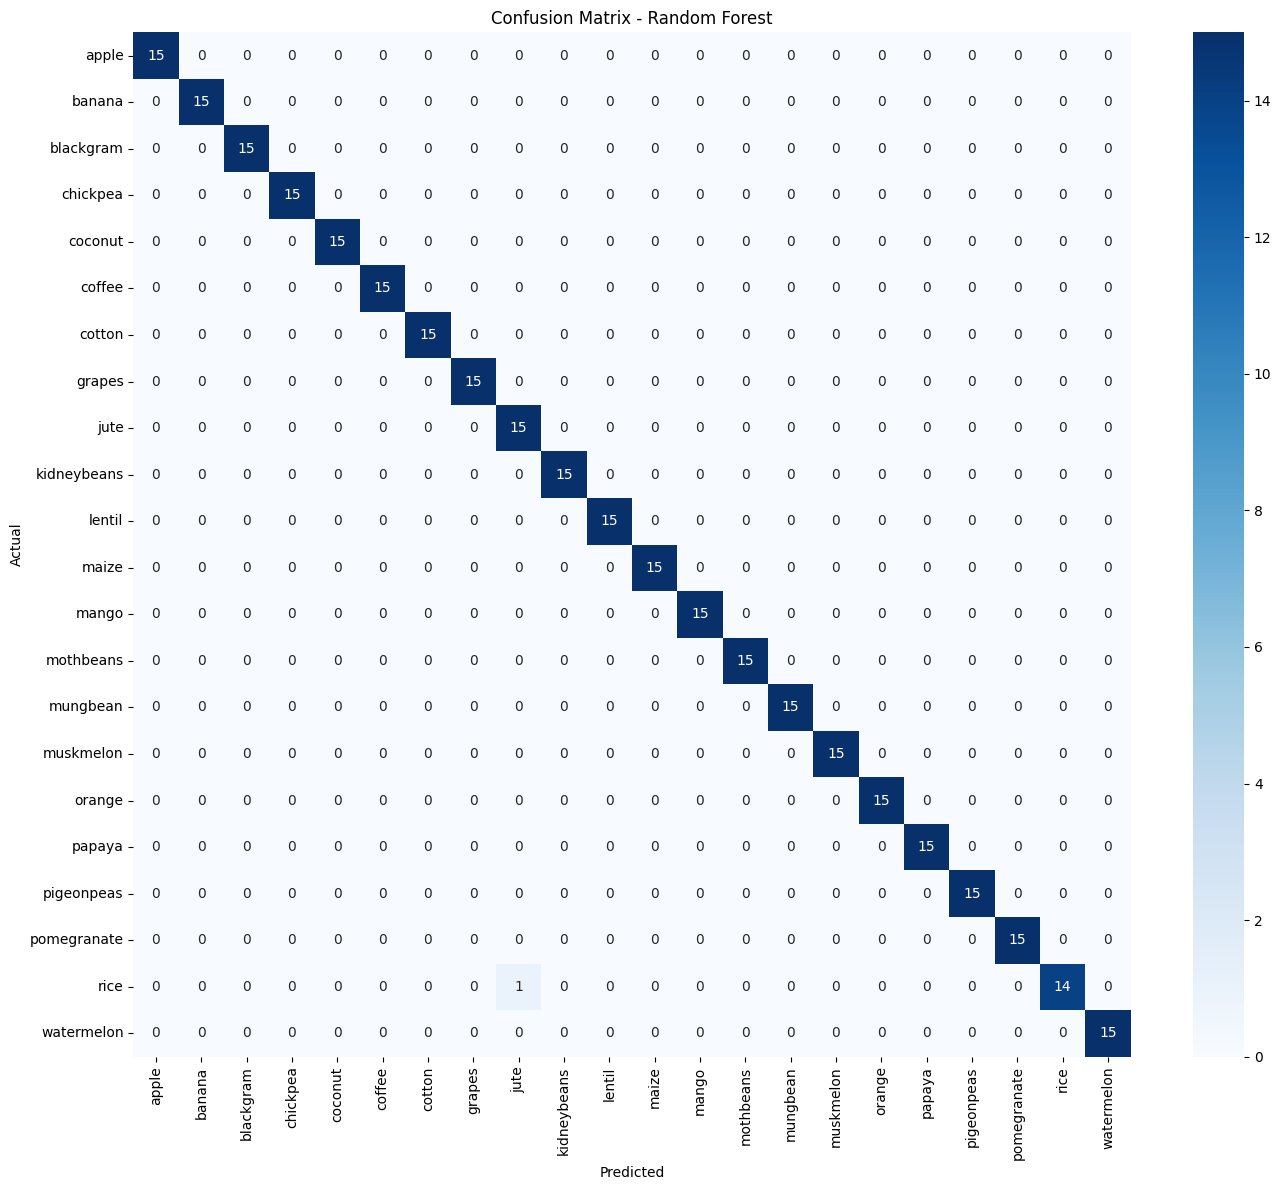

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
   blackgram       1.00      1.00      1.00        15
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
      grapes       1.00      1.00      1.00        15
        jute       0.94      1.00      0.97        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      1.00      1.00        15
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        15
   muskmelon       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00        15
      papaya       1.00    

In [11]:
# === Confusion Matrix for Best Model ===
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Mean Accuracy: 0.9941
Standard Deviation: 0.0031


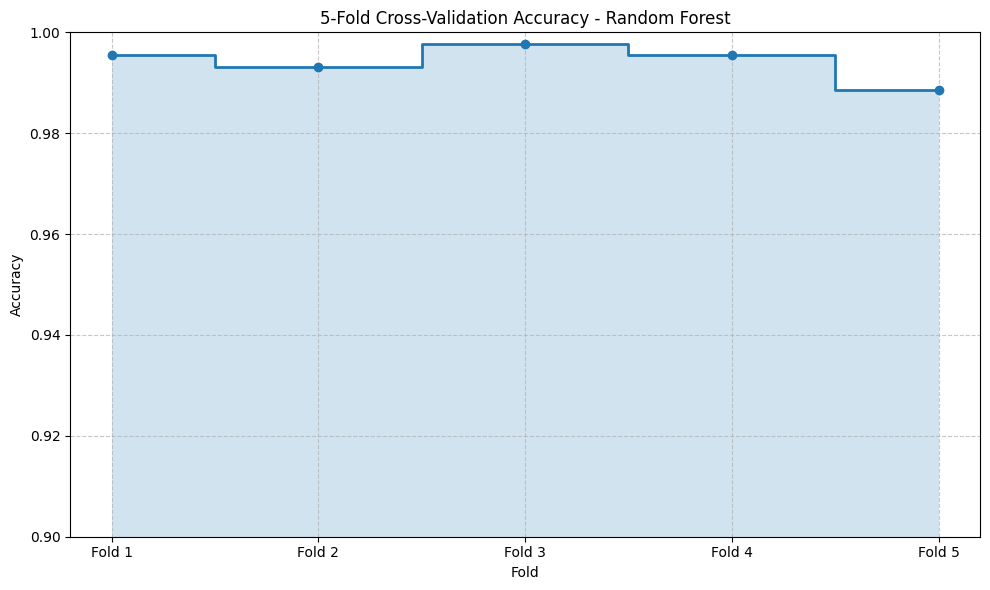

In [12]:
# === Cross-Validation ===
cv_scores = cross_val_score(RandomForestClassifier(), X_scaled, y, cv=5)
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.step(range(1, 6), cv_scores, where='mid', marker='o', linewidth=2)
plt.fill_between(range(1, 6), cv_scores, step='mid', alpha=0.2)
plt.title("5-Fold Cross-Validation Accuracy - Random Forest")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.xticks(range(1, 6), [f"Fold {i}" for i in range(1, 6)])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Generating ROC Curves (One-vs-Rest for each class):


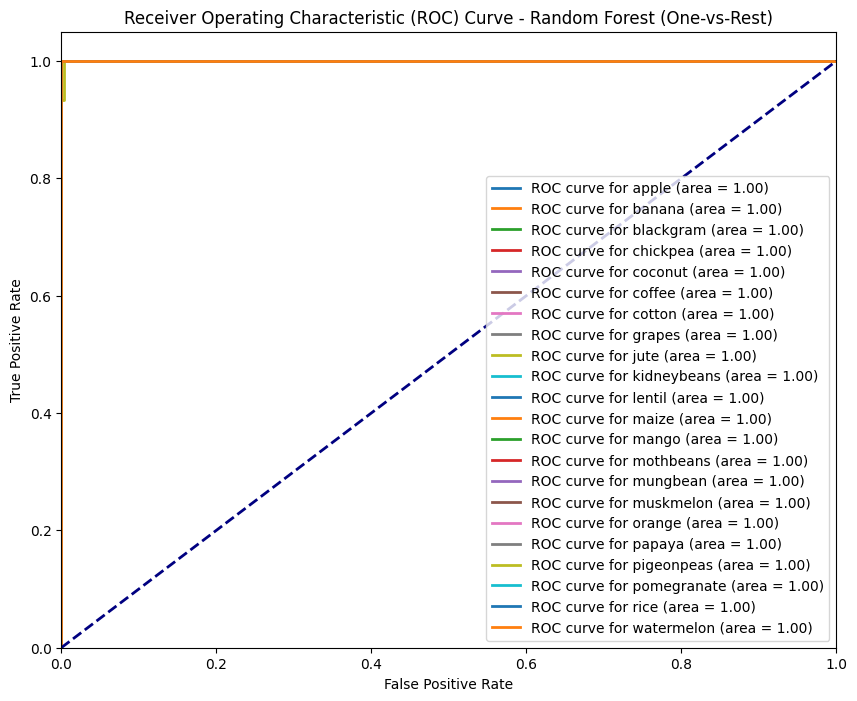

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curves for each model (One-vs-Rest)
print("Generating ROC Curves (One-vs-Rest for each class):")

for name, model in models.items():
    # Filter to only plot for Random Forest
    if name == "Random Forest":
        try:
            # Get predicted probabilities for each class
            y_prob = model.predict_proba(X_test)

            plt.figure(figsize=(10, 8))
            # Plot ROC curve for each class
            for i in range(len(label_encoder.classes_)):
                fpr, tpr, _ = roc_curve(y_test_encoded, y_prob[:, i], pos_label=i)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {label_encoder.classes_[i]} (area = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name} (One-vs-Rest)')
            plt.legend(loc="lower right")
            plt.show()

        except AttributeError:
            print(f"ROC Curve not applicable for {name} (does not have predict_proba).")
        except ValueError as e:
            print(f"Could not plot ROC curve for {name}: {e}")

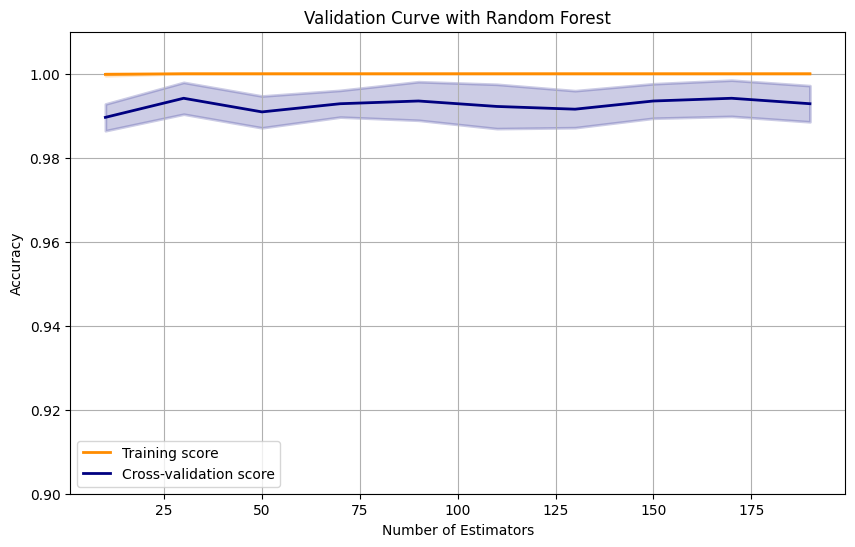

In [14]:
from sklearn.model_selection import validation_curve
import numpy as np

# Define the parameter range to evaluate
param_range = np.arange(10, 201, 20)

# Calculate the training and validation scores for the parameter
train_scores, valid_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name="n_estimators", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.01)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.show()

Train set: (1540, 7)
Validation set: (330, 7)
Test set (unused here): (330, 7)


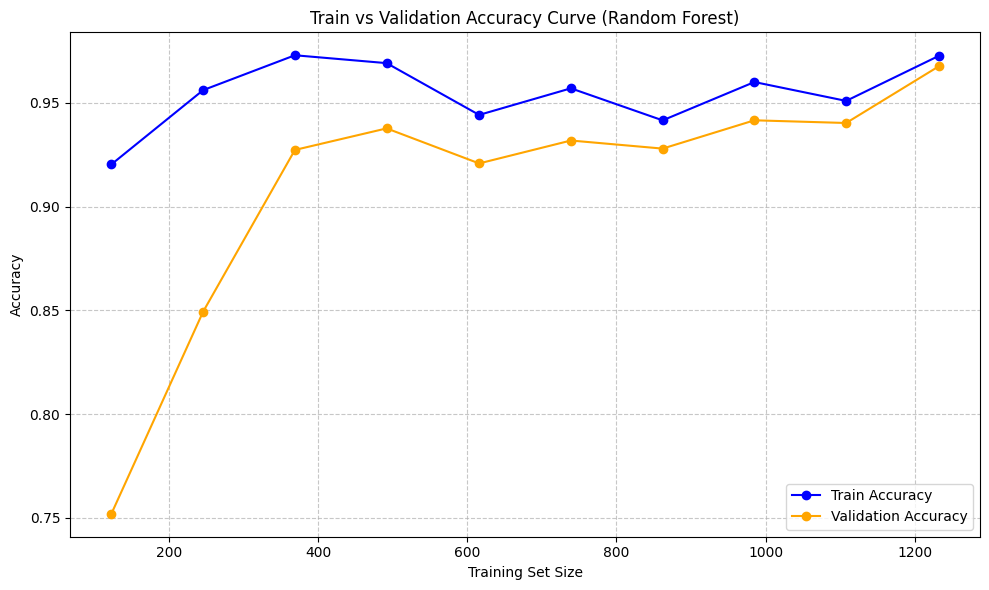

In [16]:
# === Step 1: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve

# === Step 2: Load Dataset ===
# Corrected file path to access the dataset from Google Drive
df = pd.read_csv("/content/drive/MyDrive/Data mining final crop /Crop_recommendation.csv")

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train / Validation / Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, shuffle=True, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, shuffle=True, random_state=42
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set (unused here):", X_test.shape)

# === Step 3: Random Forest with Regularization ===
model = RandomForestClassifier(
    n_estimators=30,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# === Step 4: Learning Curve (Train + Validation only) ===
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# === Plot Curves (without test accuracy) ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Train Accuracy", color="blue")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy", color="orange")

plt.title("Train vs Validation Accuracy Curve (Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Train: (1540, 7) Validation: (330, 7) Test: (330, 7)


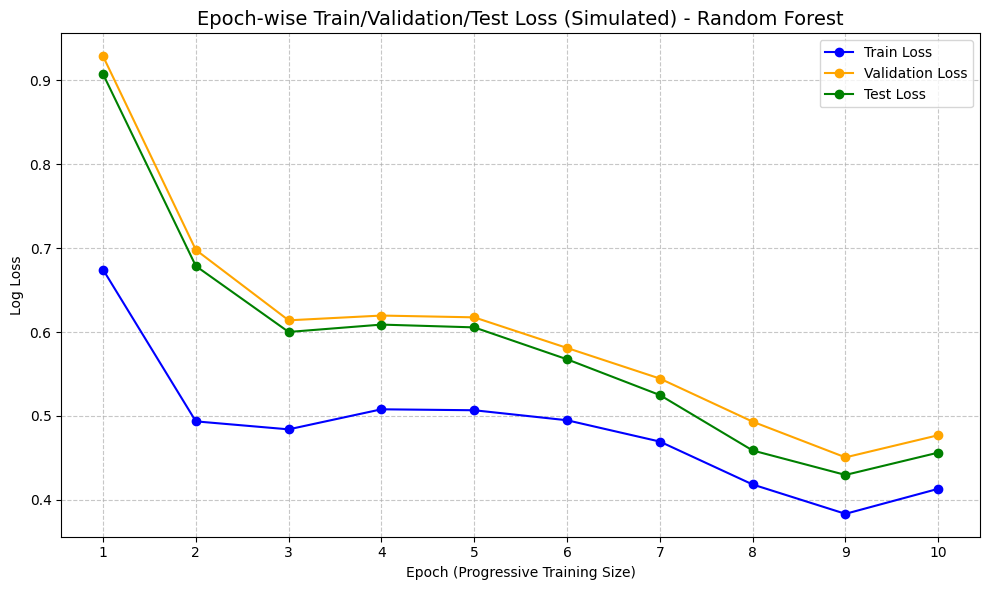

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# === Step 2: Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/Data mining final crop /Crop_recommendation.csv")

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
classes = le.classes_

X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train/Validation/Test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# Binarize labels for log_loss
y_train_bin = label_binarize(y_train, classes=np.arange(len(classes)))
y_val_bin   = label_binarize(y_val, classes=np.arange(len(classes)))
y_test_bin  = label_binarize(y_test, classes=np.arange(len(classes)))

# === Step 3: Simulate Epoch-wise Training Loss ===
train_loss_list = []
val_loss_list   = []
test_loss_list  = []

# Simulate “epochs” by progressively increasing training set size
num_steps = 10
for frac in np.linspace(0.1, 1.0, num_steps):
    n_samples = int(X_train.shape[0] * frac)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]
    y_subset_bin = y_train_bin[:n_samples]

    # Train model on subset
    rf_model = RandomForestClassifier(
        n_estimators=50, max_depth=6,
        min_samples_split=8, min_samples_leaf=5,
        random_state=42
    )
    rf_model.fit(X_subset, y_subset)

    # Predict probabilities
    y_train_prob = rf_model.predict_proba(X_subset)
    y_val_prob   = rf_model.predict_proba(X_val)
    y_test_prob  = rf_model.predict_proba(X_test)

    # Calculate log-loss
    train_loss_list.append(log_loss(y_subset_bin, y_train_prob))
    val_loss_list.append(log_loss(y_val_bin, y_val_prob))
    test_loss_list.append(log_loss(y_test_bin, y_test_prob))

# === Step 4: Plot Loss Curves ===
plt.figure(figsize=(10,6))
epochs = range(1, num_steps+1)

plt.plot(epochs, train_loss_list, 'o-', color='blue', label='Train Loss')
plt.plot(epochs, val_loss_list, 'o-', color='orange', label='Validation Loss')
plt.plot(epochs, test_loss_list, 'o-', color='green', label='Test Loss')

plt.title("Epoch-wise Train/Validation/Test Loss (Simulated) - Random Forest", fontsize=14)
plt.xlabel("Epoch (Progressive Training Size)")
plt.ylabel("Log Loss")
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Train set: (1540, 7)
Validation set: (330, 7)
Test set: (330, 7)


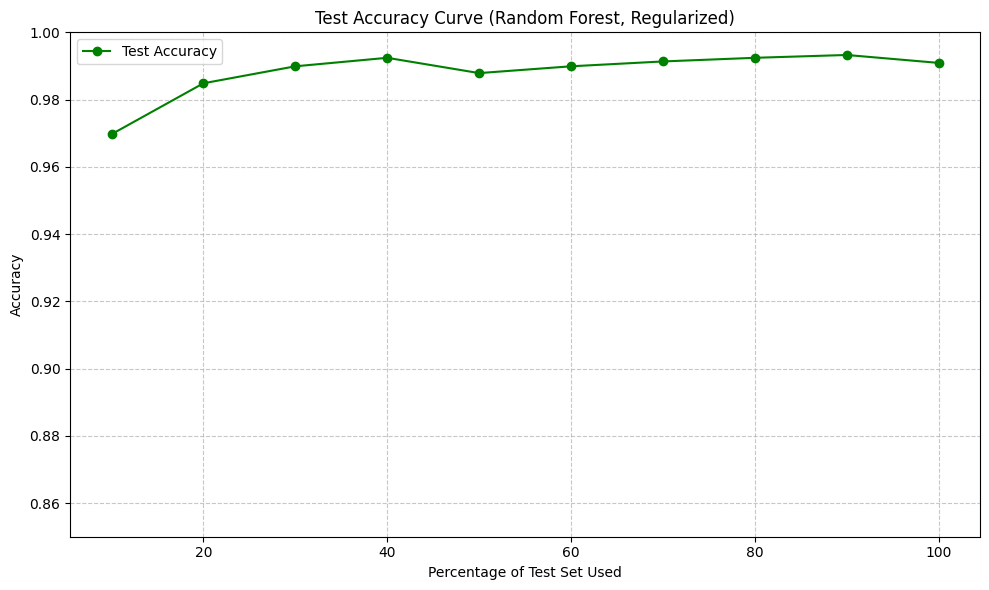


✅ Final Test Accuracy: 0.9909


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# === Step 2: Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/Data mining final crop /Crop_recommendation.csv")

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train / Validation / Test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, shuffle=True, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, shuffle=True, random_state=42
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

# === Step 3: RandomForest with Regularization (to avoid 100% accuracy) ===
model = RandomForestClassifier(
    n_estimators=50,      # কিছু কম গাছ
    max_depth=6,          # shallow trees
    min_samples_split=8,  # leaf split কম frequent
    min_samples_leaf=5,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# === Step 4: Test Accuracy Curve ===
# We'll calculate accuracy for different subsets of test data
test_sizes = np.linspace(0.1, 1.0, 10)
test_acc_curve = []

for frac in test_sizes:
    idx = int(len(X_test) * frac)
    X_subset = X_test[:idx]
    y_subset = y_test[:idx]
    y_pred = model.predict(X_subset)
    acc = accuracy_score(y_subset, y_pred)
    test_acc_curve.append(acc)

# Plot Test Accuracy Curve
plt.figure(figsize=(10,6))
plt.plot(test_sizes*100, test_acc_curve, 'o-', color='green', label='Test Accuracy')
plt.title("Test Accuracy Curve (Random Forest, Regularized)")
plt.xlabel("Percentage of Test Set Used")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.0)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✅ Final Test Accuracy: {test_acc_curve[-1]:.4f}")